In [1]:
# Deep Graph Library -DGL- Example Tutorials are simplified and CoraDataSet & MiniGCDataSets are analyzed 

# This notebook does: 1- Node Classification, 2- Edge Classification, 3- Graph Classification

# import the dgl, torch, and numpy libraries
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
import numpy as np
import matplotlib.pyplot as plt
import itertools

import networkx as nx
# download the cora graph dataset for node classification and edge classification
dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)
g = dataset[0]

Using backend: pytorch


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7


In [2]:
# View the data

print(len(g.nodes()), g.nodes()) # 2708 nodes
print(len(g.edges()[0]), len(g.edges()[1])) # 10556 edges, undirected graph, stored in two arrays as: [from] - [to]
print(g.edges()[0][:5], g.edges()[1][:5]) # view some of the connections

# check in and out degrees to see if this is directed or undirected
print(g.in_degrees()[:5]) 
print(g.out_degrees()[:5]) # it is an undirected graph, all nodes in and out degrees are the same.

2708 tensor([   0,    1,    2,  ..., 2705, 2706, 2707])
10556 10556
tensor([0, 0, 0, 1, 1]) tensor([ 633, 1862, 2582,    2,  652])
tensor([3, 3, 5, 1, 5])
tensor([3, 3, 5, 1, 5])


In [3]:
# View how a single graph is interpreted

print(g)
# it is one graph with 2708 nodes and 10556 edges. Node classifications can be done on one graph. There are 7 classes.

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [4]:
# View the properties of the nodes and edges of the graph

print(g.ndata) # outputs node features, node labels, train, test, validation masks. 
print(g.edata) # outputs attributes in edge data, just connections. (there is no edge attributes in this dataset)

{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False])}
{}


In [5]:
# View the ndata closely for one vertex, each node has an array with the size of 1433 values, mostly 0. Very sparse. 

print(g.ndata['feat'][0][:50])
first_node = g.ndata['feat'][0]
print(len(([i for i in first_node if i > 0]))) # there are 9 attributes that are not 0 for the first node. 

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
9


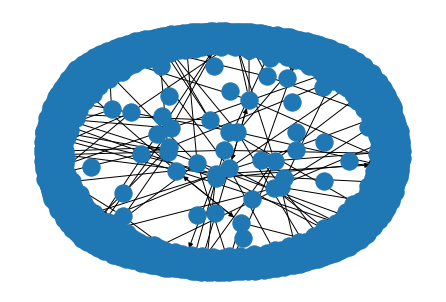

In [6]:
# View the graph to see some of the connections

g_from, g_to = g.edges()[0][:100], g.edges()[1][:100]
g_view = dgl.graph((g_from, g_to))
nx.draw(g_view.to_networkx()) # reminder that nx library is assuming these connections as directed graph. 

In [7]:
# Check the GraphConv module if it is working for this data

from dgl.nn import GraphConv
in_feat = g.ndata["feat"].shape[1] # size of the attributes
out_feat = dataset.num_classes # there are total 7 classes 


class Test_GCN(nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()
        self.conv1 = GraphConv(in_feat, out_feat)

         
    def forward(self, g, in_feat):
        result = self.conv1(g, in_feat)
        return result
    

test_model = Test_GCN(in_feat, out_feat)
logits = test_model(g, g.ndata['feat']) # GraphConv takes the g.ndata['feat'] which is torch.Size([2708, 1433])
pred = logits.argmax(1) # Compute prediction
print(pred[:5])
labels = g.ndata['label']
print(labels[:5])
print(type(pred), pred.shape, (pred == labels).sum()) 
# seems like it is all working and GraphConv net can be built 

tensor([2, 3, 1, 0, 1])
tensor([3, 4, 4, 0, 3])
<class 'torch.Tensor'> torch.Size([2708]) tensor(327)


In [8]:
# 1- Do a NODE CLASSIFICATION on this data

from dgl.nn import GraphConv

# store node attributes to variables for easy reading / writing
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
 
# define the shape of the in - hidden - out layers
in_feat = g.ndata["feat"].shape[1]
h_feat = 16 # more layers will yield slightly better results (32,50,100..)
out_feat = dataset.num_classes

# write a class with 2 convolutional layers and squeeze one activation function in between the layers
class GCN(nn.Module):
    def __init__(self, in_feat, h_feat, out_feat):
        super().__init__()
        self.conv1 = GraphConv(in_feat, h_feat)
        self.conv2 = GraphConv(h_feat, out_feat)
        
        
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# create the model and define the optimizer
model = GCN(in_feat, h_feat, out_feat)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 


In [9]:
# train the model with the loss on multi-label cross entropy criterion

for e in range(500):
    # Forward prop
    logits = model(g, features) # GraphConv takes the g.ndata['feat'] which is torch.Size([2708, 1433])

    # Compute predictions
    pred = logits.argmax(1)

    # Compute loss on training data
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Backward prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Output losses on training, validation, and test sets
    if e % 100 == 99:
        print('In epoch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {:.3f} '.format(e, loss, val_acc, test_acc))


In epoch 99, loss: 1.742, val acc: 0.680, test acc: 0.683 
In epoch 199, loss: 1.383, val acc: 0.694, test acc: 0.702 
In epoch 299, loss: 0.992, val acc: 0.718, test acc: 0.738 
In epoch 399, loss: 0.678, val acc: 0.736, test acc: 0.749 
In epoch 499, loss: 0.461, val acc: 0.748, test acc: 0.767 


### About 76% accuracy is reached with a simple 2 layer model for node classification

In [10]:
# 2- Do an EDGE CLASSIFICATION on the data.

# Extract a "positive connections" and a "negative connections" (no connections) data out of the edges list.
# Positive connections (link between nodes) are already marked but negative edges has to be extracted

u, v = g.edges()

# Shuffle the indices, split the data to train and test sets
shuffled_indices = np.random.permutation(g.number_of_edges())
test_size = int(len(shuffled_indices) * 0.1)
train_size = int(len(shuffled_indices) * 0.9)
test_pos_u, test_pos_v = u[shuffled_indices[:test_size]], v[shuffled_indices[:test_size]]
train_pos_u, train_pos_v = u[shuffled_indices[test_size:]], v[shuffled_indices[test_size:]]
print(test_pos_u[:10])


# reconstruct a graph, assign the positive and negative edges lists for training and test sets to new variables. 
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())


# create a matrix of the original positive edge connections
g_from, g_to = g.edges()[0], g.edges()[1]
mat = np.zeros([len(g_from), len(g_to)])
for i in range(len(g_from)): # row and col have the same length so one loop will suffice for creating a matrix.
    row_item_ind = g_from[i]
    col_item_ind = g_to[i]
    mat[row_item_ind][col_item_ind] = 1
print(mat[:10][:10])


# since this is a sparse matrix, finding negative connection matrix and extracting all negative connections will
# be too expensive. No need to do an node**2 long connections list
mat_negative = np.array(mat, dtype = int) - np.ones(mat.shape)
print(mat_negative[:10][:10]) # View
# this was an expensive and needless step. So, don't do it this way. 

tensor([1703,  251,  290,  706, 1232, 1003,  396,  261, 1262, 1399])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1.  0. ... -1. -1. -1.]
 [-1.  0. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


In [11]:
# It is too expensive to map a negative connection graph of a large sparse matrix. Any randomly picked 2 nodes have
# 1/600 chances to be connected. So, creating a full negative connection list is waste of money for this problem. 
# Ex: NumNodes: 2708, NumEdges: 10556, on average each node is connected to 4-5 nodes and but to the other 2700-2708

u, v = g.edges()
# create two shuffled indices. 
# with around 1/600 error rate, let's make a negative connection list of this dataset with random connection pairs
shuffled_indices1 = np.random.permutation(g.number_of_edges())
shuffled_indices2 = np.random.permutation(g.number_of_edges())
u_neg = u[shuffled_indices1]
v_neg = v[shuffled_indices2]

test_size = int(len(shuffled_indices) * 0.1)
train_size = int(len(shuffled_indices) * 0.9)
test_neg_u, test_neg_v = u_neg[shuffled_indices[:test_size]], v_neg[shuffled_indices[:test_size]]
train_neg_u, train_neg_v = u_neg[shuffled_indices[test_size:]], v_neg[shuffled_indices[test_size:]]


# assign the negative edges lists for training and test sets to new variables. 
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())


In [12]:
# Before creating a model, try using dgl's apply_edges and fn.u_add_V properties.  
    
# Reminder for: Homogeneous Graph for addition:
#     g_test = dgl.graph(([0, 1, 2, 3], [1, 2, 3, 4]))
#     g_test.ndata['h'] = torch.ones(5, 2)
#     g_test.apply_edges(lambda edges: {'x' : edges.src['h'] + edges.dst['h']})
#     print(g_test.edata['x'])

# Reminder for: Heterogeneous graph for addition:
#     g_test = dgl.heterograph({('user', 'plays', 'game'): ([0, 1, 1, 2], [0, 0, 2, 1])})
#     g_test.edges[('user', 'plays', 'game')].data['h'] = torch.ones(4, 5)
#     g_test.apply_edges(lambda edges: {'h': edges.data['h'] * 2})
#     print(g_test.edges[('user', 'plays', 'game')].data['h'])


# Test some easy to use built-in functions.
g_test = dgl.graph(([0, 1, 2, 3], [1, 2, 3, 4])) # create a graph with edges and 5 nodes 0,1..4
g_test.ndata['h'] = torch.ones(5, 2) # assign node attributes with 'ndata['h']' to those 5 nodes each having 2 attr.


# Test the addition: u['h'] is added to v['h'] and stored in edata['x']
import dgl.function as fn
g_test.apply_edges(fn.u_add_v('h', 'h', 'x'))
print(g_test.edata['x'], g_test.edata['x'].shape)


# Test the dot product: u['h'] multiplied with v['h'] and stored in edata['score']
import dgl.function as fn
g_test.ndata['h'] = torch.ones(5, 2)
# Compute a new edge feature named 'score' by a dot-product btwn the src. node feature 'h' and dest. node feature 'h'
g_test.apply_edges(fn.u_dot_v('h', 'h', 'score'))
# u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
print(g_test.edata['score'][:, 0], g_test.edata['score'][:, 0].shape) 


tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]) torch.Size([4, 2])
tensor([2., 2., 2., 2.]) torch.Size([4])


In [13]:
# Build a two-layer GraphSAGE model

from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# shuffle the graph nodes and then prepare it for training 
train_g = dgl.remove_edges(g, shuffled_indices[:test_size]) # remove 10 percent (test size) from the original data
# create the model
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16) # hidden size is picked 16 for convenience


In [14]:
# Set up the optimizer and add self connections

optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.001)

# add self connections since there might be 0-in-degree nodes in the graph and backprop will also work on them
from sklearn.metrics import roc_auc_score

train_g = dgl.add_self_loop(train_g)
train_pos_g = dgl.add_self_loop(train_pos_g)
train_neg_g = dgl.add_self_loop(train_neg_g)
print(train_g.ndata)

{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False])}


In [ ]:
# Train the model for the link prediction analysis


for e in range(500):
    # forward prop
    h_pos = model(train_pos_g, train_g.ndata['feat']) 
    h_neg = model(train_neg_g, train_g.ndata['feat']) 
    # Compute a new edge feature named 'score' by a dot-product between the
    # source node feature 'h' and destination node feature 'h'. Both for positive and negative connections
    # obtain the positive scores
    train_pos_g.ndata['h'] = h_pos
    train_pos_g.apply_edges(fn.u_dot_v('h', 'h', 'score')) # store the dot product of nodes['h'] in edata['score']
    train_pos_g.edata['score'] = train_pos_g.edata['score'][:, 0] # reshape the array to (1,:)
    pos_score = train_pos_g.edata['score'] # store the scores
    # obtain negative scores
    train_neg_g.ndata['h'] = h_neg
    train_neg_g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
    train_neg_g.edata['score'] = train_neg_g.edata['score'][:, 0]
    neg_score = train_neg_g.edata['score']
    # calculate the loss between positive scores and negative scores
    scores = torch.cat([pos_score, neg_score]) # put both scores in one array in order
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]) # set up the labels 
    loss = F.binary_cross_entropy_with_logits(scores, labels) # calculate the binary cross entropy loss

    
    # back prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 49 == 0:
        train_scores = np.array(torch.cat([pos_score, neg_score]).detach())
        labels = np.array(torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]))
        acc = roc_auc_score(labels, train_scores)
        print('In epoch: {}, training loss : {}, test accuracy: {}'.format(e, loss, acc))
    

In epoch: 0, training loss : 0.6929015517234802, test accuracy: 0.5743265276409655
In epoch: 49, training loss : 0.6574769020080566, test accuracy: 0.8061922861622117
In epoch: 98, training loss : 0.5294047594070435, test accuracy: 0.9312687479855805
In epoch: 147, training loss : 0.4717547297477722, test accuracy: 0.970551892567112
In epoch: 196, training loss : 0.4442850947380066, test accuracy: 0.9809821711613618


### 99 percent test accuracy is achieved in link prediction (edge classification). 

In [ ]:
# 3- Graph Classification with MiniGCDataset
# mini graph classification dataset is used for graph classification analysis
# class dgl.data.MiniGCDataset(num_graphs, min_num_v, max_num_v)
# num_graphs: number of graphs in this dataset
# min_num_v: minimum number of nodes for graphs
# max_num_v: maximum number of nodes for graphs

from dgl.data import MiniGCDataset
from res.plot_lib import set_default
set_default(figsize=(3, 3), dpi=150)

In [ ]:
# Generate artifical graph dataset with DGL
# The datset contains 8 different types of graphs: 
# ('cycle','star','wheel','lollipop','hypercube','grid','clique','circular ladder')

trainset = MiniGCDataset(500, 10, 15) # create 500 of randomly picked graphs between 8 to 15 nodes for training
testset = MiniGCDataset(100, 10, 15)

# add features to the nodes (in * out degrees to each node) 
# add features to the edges (just add 1 to each edge to represent a simple connection)
def add_features(dataset):
    for (graph, _) in dataset:
        in_degrees = graph.in_degrees() # in degrees to each node
        out_degrees = graph.out_degrees() # in degrees to each node
        in_and_out_degrees = in_degrees * out_degrees  # vector multiplication
        graph.ndata['attr'] = in_and_out_degrees.view(-1, 1).float() / 100 # max number of nodes
        graph.edata['attr'] = torch.ones(graph.number_of_edges(), 1)
    return dataset


trainset = add_features(trainset)
testset = add_features(testset)

print(len(trainset))
print(trainset[0][0])

In [ ]:
# Add features to the nodes (in * out degrees to each node) 
# add features to the edges (just add 1 to each edge to represent a simple connection)

def add_features(dataset):
    for (graph, _) in dataset:
        in_degrees = graph.in_degrees() # in degrees to each node
        out_degrees = graph.out_degrees() # in degrees to each node
        in_and_out_degrees = in_degrees * out_degrees # vector multiplication
        graph.ndata['attr'] = in_and_out_degrees.view(-1, 1).float() # max number of nodes
        graph.edata['attr'] = torch.ones(graph.number_of_edges(), 1)
    return dataset


trainset = add_features(trainset)
testset = add_features(testset)

print(len(trainset))
print(trainset[0][:5])

# Ex: [Graph(num_nodes=13, num_edges=57,
#       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
#       edata_schemes={}), tensor([1])]

In [ ]:
# Visualize a randomly picked graph

print('data:', trainset[0], 'label:', trainset[1])
# print(trainset[0][0].ndata['feat'], trainset[0][0].edata['feat']) 
plt.figure()
nx.draw(trainset[0][0].to_networkx(), with_labels=True, node_color='cyan', edge_color='red')
print(trainset[0][0].ndata['attr'] , trainset[200][0].ndata['attr'])

In [ ]:
# Consolidate a few graphs into each batch. For simplicity, the solution below is made for 1 graph ==> 1 batch
# It is common to pick a number between 5-20 graphs for a batch. 

from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

print(len(trainset), len(testset))
num_examples = len(trainset)
num_train = int(num_examples * 0.8)
num_test = len(testset)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_test))

train_dataloader = GraphDataLoader(
    trainset, sampler=train_sampler, batch_size=1, drop_last=False)
test_dataloader = GraphDataLoader(
    testset, sampler=test_sampler, batch_size=1, drop_last=False)


In [ ]:
# See if the trainloader iterable object is working

it = iter(train_dataloader)
batch = next(it)
print(batch)
print(it.next())

In [ ]:
# Review the properties of each batch

batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())
print('Node feature dimensionality:', trainset.max_num_v)
print('Number of graph categories:', trainset.num_classes)

In [ ]:
# View 1 batch (1 graph)

batched_graph

In [ ]:
# Build a 2 layer NN with GraphConv

from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')


# Create the model with given dimensions
model = GCN(1, 16, trainset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model: 

for epoch in range(500):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 49 == 0:
        # testing
        num_correct = 0
        num_tests = 0
        for batched_graph, labels in test_dataloader:
            pred = model(batched_graph, batched_graph.ndata['attr'].float())
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        print('at:', epoch, 'Test accuracy %:', num_correct / num_tests * 100)
        

### 84 percent test accuracy is achieved in graph classification. 